In [ ]:
%pip install crunch-cli --upgrade --quiet --progress-bar off

In [1]:
!crunch setup-notebook structural-break aNRPER4ArVgrtxWSud9oHBmu

crunch-cli, version 6.5.0
delete /kaggle/working/.crunchdao
main.py: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/submissions/21754/main.py (3924 bytes)
notebook.ipynb: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/submissions/21754/notebook.ipynb (19917 bytes)
requirements.txt: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/submissions/21754/requirements.original.txt (178 bytes)
data/X_train.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/y_train.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_test.reduced.parquet: down

In [2]:
import crunch
import os
import joblib
import scipy
import sklearn.metrics

crunch = crunch.load_notebook()

loaded inline runner with module: <module '__main__'>

cli version: 6.5.0
available ram: 31.35 gb
available cpu: 4 core
----


In [3]:
X_train, y_train, X_test = crunch.load_data()

data/X_train.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_train.parquet: already exists, file length match
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/X_test.reduced.parquet: already exists, file length match
data/y_train.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_train.parquet: already exists, file length match
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
data/y_test.reduced.parquet: already exists, file length match


In [4]:
X_train

value  period
id    time                  
0     0    -0.005564       0
      1     0.003705       0
      2     0.013164       0
      3     0.007151       0
      4    -0.009979       0
...              ...     ...
10000 2134  0.001137       1
      2135  0.003526       1
      2136  0.000687       1
      2137  0.001640       1
      2138  0.001074       1

[23715734 rows x 2 columns]

In [5]:
y_train

id
0        False
1        False
2         True
3        False
4        False
         ...  
9996     False
9997     False
9998     False
9999     False
10000     True
Name: structural_breakpoint, Length: 10001, dtype: bool

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew, kurtosis, linregress
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Training

In [7]:
from catboost import CatBoostClassifier, Pool

cb_params = {
    'iterations': 5000,
    'early_stopping_rounds': 500,
    'learning_rate': 1e-2,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    # 'depth': 2,
    # 'l2_leaf_reg': 4,
    # 'bagging_temperature': 2,
    # 'random_strength': 1,
    # 'border_count': 63,
    # 'od_type': 'IncToDec',
    'verbose': 100,
    # 'subsample': 1.0,
    'random_seed': 42,
    'task_type': 'CPU',
}

In [48]:
def extract_features(group):
    features = {}
    
    before = group[group['period'] == 0]['value']
    after = group[group['period'] == 1]['value']

    with np.errstate(divide='ignore', invalid='ignore', over='ignore', under='ignore'):


        for tag, series in [('before', before), ('after', after)]:
            if series.empty: continue
                
            features[f'mean_{tag}'] = series.mean()
            features[f'std_{tag}'] = series.std()
            features[f'skew_{tag}'] = skew(series)
            features[f'kurtosis_{tag}'] = kurtosis(series)
            features[f'min_{tag}'] = series.min()
            features[f'max_{tag}'] = series.max()
            features[f'iqr_{tag}'] = series.quantile(0.75) - series.quantile(0.25)
            features[f'median_{tag}'] = series.median()
            features[f'range_{tag}'] = series.max() - series.min()
            features[f'var_{tag}'] = series.var()
            features[f'cv_{tag}'] = series.std() / (series.mean() + 1e-5)
            features[f'slope_{tag}'] = np.polyfit(np.arange(len(series)), series, 1)[0]
            features[f'mean_diff_{tag}'] = series.diff().mean()
            features[f'std_diff_{tag}'] = series.diff().std()
            features[f'spike_count_{tag}'] = np.sum(np.abs(series.diff()) > (2 * series.std()))
            features[f'spike_count_{tag}'] = np.sum(np.abs(series.diff()) > (2 * series.std()))
            features[f'rolling_mean_diff_{tag}'] = series.rolling(5).mean().diff().mean()
    
        if not before.empty and not after.empty:
            features['delta_mean'] = after.mean() - before.mean()
            features['delta_std'] = after.std() - before.std()
            features['ratio_mean'] = after.mean() / (before.mean() + 1e-5)
            features['delta_median'] = after.median() - before.median()
            features['delta_iqr'] = (after.quantile(0.75) - after.quantile(0.25)) - \
                                    (before.quantile(0.75) - before.quantile(0.25))
            features['ratio_std'] = after.std() / (before.std() + 1e-5)
            features['change_in_slope'] = (
                np.polyfit(np.arange(len(after)), after, 1)[0] - 
                np.polyfit(np.arange(len(before)), before, 1)[0]
            )

    return pd.Series(features)

In [49]:
feature_df = X_train.groupby(level='id').apply(extract_features)
feature_df.reset_index(inplace=True)

full_df = pd.concat([feature_df, y_train], axis=1)

copy_df = full_df.copy()

x = copy_df.drop(columns=['structural_breakpoint'])
y = copy_df['structural_breakpoint']
x_train_final, x_valid_final, y_train_final, y_valid_final = train_test_split(x, y, random_state=42)


train_pool = Pool(x_train_final, y_train_final)
valid_pool = Pool(x_valid_final, y_valid_final)

In [42]:
cb_params = {
    'iterations': 10000,
    'early_stopping_rounds': 800,
    'learning_rate': 1e-2,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'depth': 8,
    # 'l2_leaf_reg': 8,
    # 'bagging_temperature': 2,
    # 'random_strength': 1,
    'border_count': 255,
    # 'od_type': 'IncToDec',
    'verbose': 100,
    # 'subsample': 1.0,
    'random_seed': 42,
    'task_type': 'CPU',
}

model = CatBoostClassifier(**cb_params)
model.fit(train_pool, eval_set=[train_pool, valid_pool])
# model.fit(x, y)

0:	test: 0.5908020	test1: 0.5805100	best: 0.5805100 (0)	total: 34.4ms	remaining: 5m 43s
100:	test: 0.7870396	test1: 0.6535535	best: 0.6540156 (98)	total: 2.29s	remaining: 3m 44s
200:	test: 0.8268295	test1: 0.6649067	best: 0.6650655 (199)	total: 4.68s	remaining: 3m 48s
300:	test: 0.8525182	test1: 0.6691550	best: 0.6691550 (300)	total: 7.28s	remaining: 3m 54s
400:	test: 0.8746213	test1: 0.6710284	best: 0.6710337 (364)	total: 9.45s	remaining: 3m 46s
500:	test: 0.8956213	test1: 0.6723883	best: 0.6725547 (458)	total: 11.7s	remaining: 3m 41s
600:	test: 0.9116660	test1: 0.6744236	best: 0.6745279 (597)	total: 13.8s	remaining: 3m 36s
700:	test: 0.9257759	test1: 0.6752737	best: 0.6752737 (700)	total: 16s	remaining: 3m 32s
800:	test: 0.9383450	test1: 0.6754030	best: 0.6756087 (743)	total: 18.2s	remaining: 3m 29s
900:	test: 0.9485970	test1: 0.6755240	best: 0.6757539 (823)	total: 20.4s	remaining: 3m 26s
1000:	test: 0.9580596	test1: 0.6762819	best: 0.6762819 (1000)	total: 22.6s	remaining: 3m 23s
110

In [43]:
valid_preds = model.predict_proba(x_valid_final)[:, 1]
roc_auc_score(y_valid_final, valid_preds)

0.6794115467055117

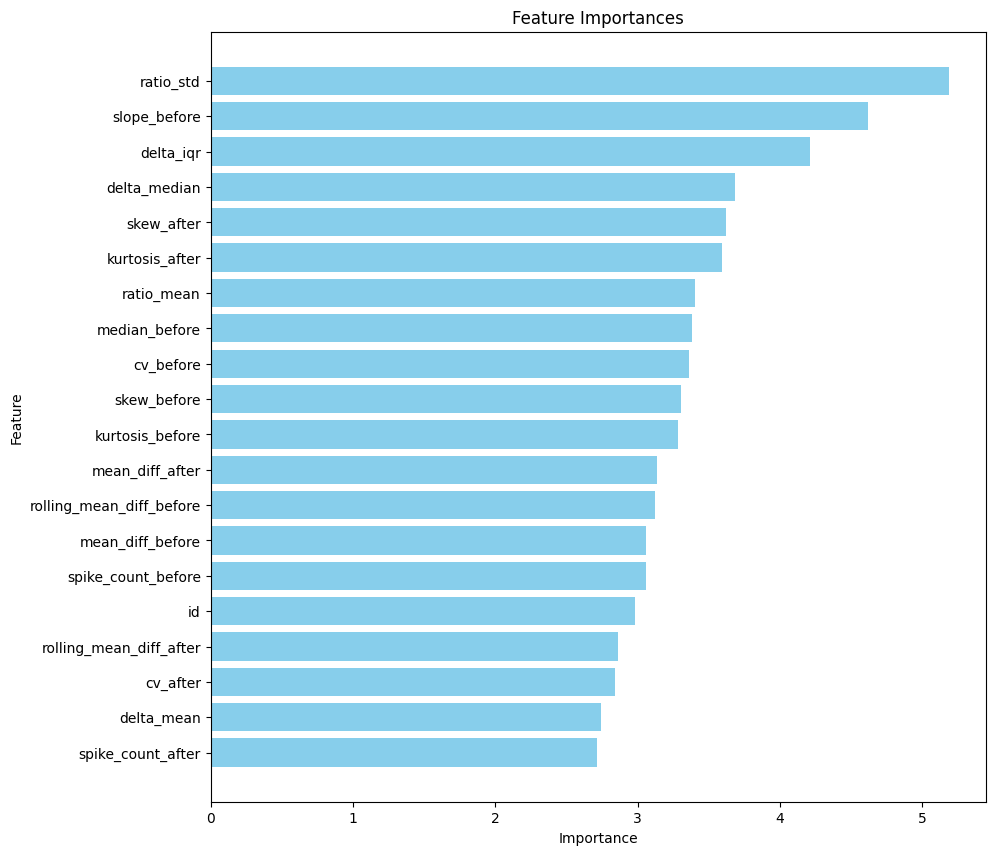

In [44]:
importances = model.get_feature_importance()
feature_names = x_train_final.columns.tolist()

sorted_idx = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_idx]
sorted_features = [feature_names[i] for i in sorted_idx]

plt.figure(figsize=(10, 10))
plt.barh(sorted_features[:20], sorted_importances[:20], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# Crunch Submission

In [50]:
def train(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    model_directory_path: str,
):
    feature_df = X_train.groupby(level='id').apply(extract_features)
    feature_df.reset_index(inplace=True)
    
    full_df = pd.concat([feature_df, y_train], axis=1)
    
    copy_df = full_df.copy()
    
    x = copy_df.drop(columns=['structural_breakpoint'])
    y = copy_df['structural_breakpoint']
    x_train_final, x_valid_final, y_train_final, y_valid_final = train_test_split(x, y, random_state=42)
    
    
    train_pool = Pool(x_train_final, y_train_final)
    valid_pool = Pool(x_valid_final, y_valid_final)

    cb_params = {
        'iterations': 10000,
        'early_stopping_rounds': 800,
        'learning_rate': 1e-2,
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'depth': 8,
        # 'l2_leaf_reg': 8,
        # 'bagging_temperature': 2,
        # 'random_strength': 1,
        'border_count': 255,
        # 'od_type': 'IncToDec',
        'verbose': 100,
        # 'subsample': 1.0,
        'random_seed': 42,
        'task_type': 'CPU',
    }
    
    model = CatBoostClassifier(**cb_params)
    model.fit(train_pool, eval_set=[train_pool, valid_pool])

    joblib.dump(model, os.path.join(model_directory_path, 'model.joblib'))

In [51]:
def infer(
    X_test,
    model_directory_path,
):
    model = joblib.load(os.path.join(model_directory_path, 'model.joblib'))

    yield

    # # X_test can only be iterated once.ok w
    # # Before getting the next dataset, you must predict the current one.
    for dataset in X_test:
        test_feature_df = dataset.groupby(level='id').apply(extract_features)
        test_feature_df.reset_index(inplace=True)

        prediction = model.predict_proba(test_feature_df)[:, 1]
        yield prediction

In [52]:
crunch.test()

07:05:58 no forbidden library found
07:05:58 
07:05:59 started
07:05:59 running local test
07:05:59 internet access isn't restricted, no check will be done
07:05:59 
07:05:59 starting unstructured loop...
07:05:59 executing - command=train


data/X_train.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_train.parquet: already exists, file length match
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/X_test.reduced.parquet: already exists, file length match
data/y_train.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_train.parquet: already exists, file length match
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
data/y_test.reduced.parquet: already exists, file length match
0:	test: 0.5908020	test1: 0.5805100	best: 0.5805100 (0)	total: 33.8ms	remaining: 5m 38s
100:	test: 0.7870396	test1: 0.653

07:09:38 executing - command=infer
07:09:39 checking determinism by executing the inference again with 30% of the data (tolerance: 1e-08)
07:09:39 executing - command=infer
07:09:40 determinism check: passed
07:09:40 save prediction - path=data/prediction.parquet
07:09:40 ended
07:09:40 duration - time=00:03:41
07:09:40 memory - before="1.31 GB" after="1.33 GB" consumed="14.87 MB"


In [53]:
prediction = pd.read_parquet("data/prediction.parquet")
prediction

,prediction
id,
10001,0.172239
10002,0.316101
10003,0.133430
10004,0.066662
10005,0.190958
...,...
10097,0.237467
10098,0.142771
10099,0.356541


In [54]:
target = pd.read_parquet("data/y_test.reduced.parquet")["structural_breakpoint"]

roc_auc_score(target,prediction)

0.7333333333333334